In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm, trange
import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import os
import pandas as pd
from torch.utils.data import DataLoader
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
from unet_superresolution import UNetSR
from imagenet_torch import ImageNet1000
from smoothened_estimate import SmoothenedModel
from adv import AttackerModel
from evaluate_adv import seek_perturbation, test, perform_evaluation, tensor_to_imshow

In [21]:
# evaluate on whole test set
os.chdir('/faidra/project')
test_data = ImageNet1000('./imagenet-mini/val', scaling_factor=2, use_cache=True)
test_loader = torch.utils.data.Subset(test_data, range(0, 1000, 1))

Loading dataset into cache...


In [6]:
# evaluate on whole test set
os.chdir('/faidra/project')
test_data = ImageNet1000('./imagenet-mini/val', scaling_factor=2, use_cache=True)
test_subset = torch.utils.data.Subset(test_data, range(0, 10, 1))
test_dataloader = DataLoader(test_subset, batch_size=1, pin_memory=True, shuffle=False)

device = 'cuda:1'
modelname = 'model_02_50.pt'
rs_base_model = torch.load(modelname).to(device)
sigma = 0.2
k=100

smoothing_model = SmoothenedModel(rs_base_model, sigma, device)
# smoothing_model = model
normalize_inverse = transforms.Normalize(mean=[-0.4882/0.2777, -0.4431/0.2665, -0.3946/0.2739],
                                            std=[1/0.2777, 1/0.2665, 1/0.2739])
mse_loss = nn.MSELoss()

lr, hr = test_data[0]
# the dimensionality is later used to scale the adversarial perturbations.
# print(lr.shape)
n = np.prod(lr.shape)

# will be multiplied by math.sqrt(n), where n is the image dimension (e.g. 3*32*32)

# number of PGD iterations; with value 1 it is a variant of FastFGSM (not necessarily sufficiently strong attack)
adv_iterations = 50

psnrs_rs = []
ssims_rs = []

for eps_rel in [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    # specific attack settings defined below
    # needs to be adapted for different settings (e.g. for classification one usually needs restarts and more iterations)
    eps = eps_rel * math.sqrt(n) # eps_rel * 277
    attack_kwargs01 = {
        'constraint': "2",
        'eps': eps,
        'step_size': 2.5 * (eps / adv_iterations),
        'iterations': adv_iterations,
        'random_start': True,
        'random_restarts': 2,
        'use_best': False,
        'random_mode': "uniform_in_sphere"
    }

    smooth_mse = []
    smooth_psnr = []
    smooth_ssim = []

    for idx, (low_img, high_img) in enumerate(test_dataloader):
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        rs_adv_perturbed_input, rs_base_model_pred = seek_perturbation(
            # uncomment one of the following two lines to attack either the adversarial or the randomized smoothing model
            smoothing_model, low_img, high_img, make_adv=True, **attack_kwargs01)
            #rs_base_model, low_img, high_img, make_adv=True, **attack_kwargs01)
        
        # uncomment one of the two following lines to evaluate either the adversarial or the randomized smoothing model
        # smooth = smoothing_model(rs_adv_perturbed_input)
        smooth = rs_base_model_pred
        smooth = torch.clamp(smooth, 0., 1.)
        
        mse_smooth = mse_loss(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_mse.append(mse_smooth)

        psnr_smooth = peak_signal_noise_ratio(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_psnr.append(psnr_smooth)

        ssim_smooth = structural_similarity_index_measure(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_ssim.append(ssim_smooth)

    mse = sum(smooth_mse)/len(test_dataloader)
    psnr = sum(smooth_psnr)/len(test_dataloader)
    ssim = sum(smooth_ssim)/len(test_dataloader)
    psnrs_rs.append(psnr)
    ssims_rs.append(ssim)

Loading dataset into cache...


In [7]:
psnrs = []
ssims = []

for eps_rel in [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    # specific attack settings defined below
    # needs to be adapted for different settings (e.g. for classification one usually needs restarts and more iterations)
    eps = eps_rel * math.sqrt(n) # eps_rel * 277
    attack_kwargs01 = {
        'constraint': "2",
        'eps': eps,
        'step_size': 2.5 * (eps / adv_iterations),
        'iterations': adv_iterations,
        'random_start': True,
        'random_restarts': 0,
        'use_best': False,
        'random_mode': "uniform_in_sphere"
    }

    smooth_mse = []
    smooth_psnr = []
    smooth_ssim = []

    for idx, (low_img, high_img) in enumerate(test_dataloader):
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        rs_adv_perturbed_input, rs_base_model_pred = seek_perturbation(
            # uncomment one of the following two lines to attack either the adversarial or the randomized smoothing model
            # smoothing_model, low_img, high_img, make_adv=True, **attack_kwargs01)
            rs_base_model, low_img, high_img, make_adv=True, **attack_kwargs01)
        
        # uncomment one of the two following lines to evaluate either the adversarial or the randomized smoothing model
        smooth = smoothing_model(rs_adv_perturbed_input)
        # smooth = rs_base_model_pred
        smooth = torch.clamp(smooth, 0., 1.)
        
        mse_smooth = mse_loss(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_mse.append(mse_smooth)

        psnr_smooth = peak_signal_noise_ratio(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_psnr.append(psnr_smooth)

        ssim_smooth = structural_similarity_index_measure(
            smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
        smooth_ssim.append(ssim_smooth)

    mse = sum(smooth_mse)/len(test_dataloader)
    psnr = sum(smooth_psnr)/len(test_dataloader)
    ssim = sum(smooth_ssim)/len(test_dataloader)
    psnrs.append(psnr)
    ssims.append(ssim)
    

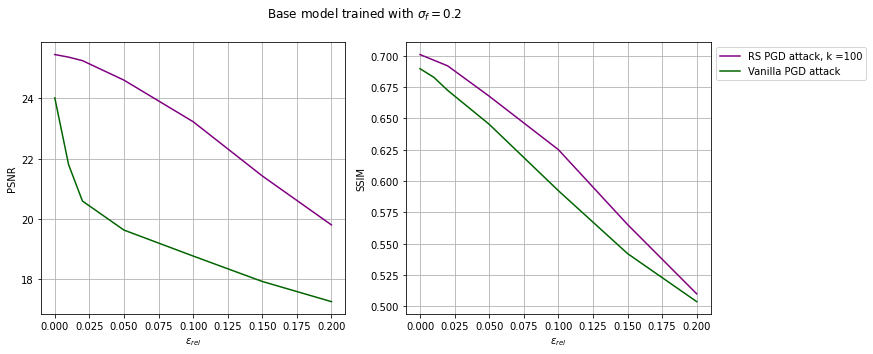

In [8]:

fig = plt.figure(figsize=(12, 5))
fig.suptitle(f'Base model trained with ' + r'$\sigma_{f}=0.2$')
grid = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(grid[0, 0])
ax1.set_xlabel(r'$\epsilon_{rel}$')
ax1.set_ylabel('PSNR')
ax1.grid(which='both')

ax2 = plt.subplot(grid[0, 1])
ax2.set_xlabel(r'$\epsilon_{rel}$')
ax2.set_ylabel('SSIM')
ax2.grid(which='both')


ax1.plot([0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2], psnrs_rs, label='RS PGD attack, k =' + f'{k}', c='purple')
ax1.plot([0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2], psnrs, label='Vanilla PGD attack', c='darkgreen')
ax2.plot([0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2], ssims_rs, label='RS PGD attack, k ='+f'{k}', c='purple')
ax2.plot([0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2], ssims, label='Vanilla PGD attack', c='darkgreen')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [29]:
# evaluate on whole test set
os.chdir('/faidra/project')
test_data = ImageNet1000('./imagenet-mini/val', scaling_factor=2, use_cache=True)
test_subset = torch.utils.data.Subset(test_data, range(0, 100, 1))
test_dataloader = DataLoader(test_subset, batch_size=1, pin_memory=True, shuffle=False)

device = 'cuda:1'
modelname = 'model_02_50.pt'
rs_base_model = torch.load(modelname).to(device)
sigma = 0.2

smoothing_model = SmoothenedModel(rs_base_model, sigma, device)
# smoothing_model = model
normalize_inverse = transforms.Normalize(mean=[-0.4882/0.2777, -0.4431/0.2665, -0.3946/0.2739],
                                            std=[1/0.2777, 1/0.2665, 1/0.2739])
mse_loss = nn.MSELoss()

lr, hr = test_data[0]
# the dimensionality is later used to scale the adversarial perturbations.
# print(lr.shape)
n = np.prod(lr.shape)

# will be multiplied by math.sqrt(n), where n is the image dimension (e.g. 3*32*32)

# number of PGD iterations; with value 1 it is a variant of FastFGSM (not necessarily sufficiently strong attack)
adv_iterations = 10

psnrs_rs = []
ssims_rs = []
eps_rel=0.01

# specific attack settings defined below
# needs to be adapted for different settings (e.g. for classification one usually needs restarts and more iterations)
eps = eps_rel * math.sqrt(n) # eps_rel * 277
attack_kwargs01 = {
    'constraint': "2",
    'eps': eps,
    'step_size': 2.5 * (eps / adv_iterations),
    'iterations': adv_iterations,
    'random_start': True,
    'random_restarts': 0,
    'use_best': False,
    'random_mode': "uniform_in_sphere"
}

smooth_mse = []
smooth_psnr = []
smooth_ssim = []
norms = []

for idx, (low_img, high_img) in enumerate(test_dataloader):
    low_img = low_img.to(device)
    high_img = high_img.to(device)

    rs_adv_perturbed_input, rs_base_model_pred = seek_perturbation(
        # uncomment one of the following two lines to attack either the adversarial or the randomized smoothing model
        #smoothing_model, low_img, high_img, make_adv=True, **attack_kwargs01)
        rs_base_model, low_img, high_img, make_adv=True, **attack_kwargs01)
    norms.append(np.linalg.norm((rs_adv_perturbed_input-low_img).detach().cpu().numpy()))
    # uncomment one of the two following lines to evaluate either the adversarial or the randomized smoothing model
    # smooth = smoothing_model(rs_adv_perturbed_input)
    smooth = rs_base_model_pred
    smooth = torch.clamp(smooth, 0., 1.)
    
    mse_smooth = mse_loss(
        smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
    smooth_mse.append(mse_smooth)

    psnr_smooth = peak_signal_noise_ratio(
        smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
    smooth_psnr.append(psnr_smooth)

    ssim_smooth = structural_similarity_index_measure(
        smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
    smooth_ssim.append(ssim_smooth)

mse = sum(smooth_mse)/len(test_dataloader)
psnr = sum(smooth_psnr)/len(test_dataloader)
ssim = sum(smooth_ssim)/len(test_dataloader)
psnrs_rs.append(psnr)
ssims_rs.append(ssim)

norm_l2 = sum(norms)/len(test_dataloader)
print(eps)
print(norm_l2)

Loading dataset into cache...
2.771281292110204
2.771281201839447


In [26]:
print(norm_l2)
print(eps)

13.8564058303833
13.856406460551021
